# Example of NaiveFea

The aim of the project is running as fast as the reporter. (But it has a low level of knowledge now.)

In [1]:
import pygmsh
import NaiveFea
from NaiveFea.constitutive import LinearMaterial
from NaiveFea.analysis import LinearFea

In [2]:
# generate mesh by pygmsh
with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(
        [
            [0.0, 0.0],
            [1.0, 0.0],
            [1.0, 1.0],
            [0.0, 1.0],
        ],
        mesh_size=0.1,
    )
    mesh = geom.generate_mesh()

In [3]:
# set material
material=LinearMaterial(10.0,0.3)
NaiveFea.uniform_material(mesh,material)

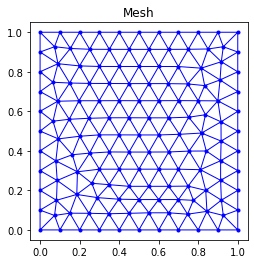

In [4]:
# instantiate fea according to mesh
fea=LinearFea(mesh)
# show the mesh
fea.plot_mesh()

In [5]:
# set boundary conditions
# left bound is fixed, and right bound apply fx=1.0
x_fix={}
y_fix={}
f_given={}
for index,position in enumerate(mesh.points):
    x=position[0].tolist()
    y=position[1].tolist()
    if x<1e-6:
        x_fix.update({index:0.0})
        y_fix.update({index:0.0})
    if 1.0-x<1e-6 and abs(y-0.5)<1e-2:
        f_given.update({index:(1.0e-4,0.0)})
fea.set_conditions(x_fix,y_fix,f_given)

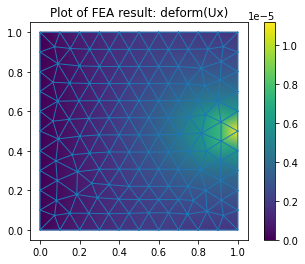

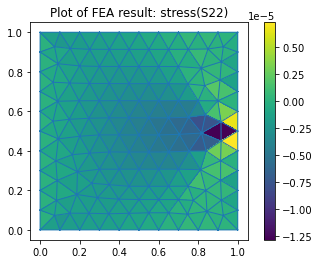

In [6]:
# submit for analyzing
fea.submit()
# show result, deformation and stress for example
fea.plot('deform','Ux')
fea.plot('stress','S22')
# all plot choice:
#   deform: Ux, Uy
#   force: Fx, Fy
#   strain: e11, e22, e12
#   stress: S11, S22, S12